In [1]:
# ALL IMPORTS

import json
import os
from collections import defaultdict

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch

import matplotlib.pyplot as plt
import numpy as np

import cv2

In [2]:
# mount our Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip images in Google Drive

!unzip '/content/drive/MyDrive/Colab Notebooks/APS360/Project/chessred2k.zip' -d '/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K'

Archive:  /content/drive/MyDrive/Colab Notebooks/APS360/Project/chessred2k.zip
   creating: /content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/
   creating: /content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/0/
  inflating: /content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/0/G000_IMG000.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/0/G000_IMG001.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/0/G000_IMG002.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/0/G000_IMG003.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/0/G000_IMG004.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/0/G000_IMG005.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/0/G000_IMG006.jpg  
  inflating:

In [3]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K'
annotation_dir = '/content/drive/MyDrive/Colab Notebooks/APS360/Project/annotations.json'

with open(annotation_dir, "r") as f:
            annotations = json.load(f)

In [66]:
# messing around with annotations.json

print(annotations.keys(), "\n")
print(annotations['categories'], "\n") # id map for each type of piece

print(annotations['splits']['chessred2k']['train'])
print(annotations['splits']['chessred2k']['val'])
print(annotations['splits']['chessred2k']['test'])

print((annotations['splits']['chessred2k']['train']['image_ids']))

print(annotations['annotations']['pieces'][0]) # all 223,804 piece annotations for 10800 images
print(annotations['annotations']['corners'][0])

print(annotations['images'][0])

dict_keys(['info', 'images', 'annotations', 'categories', 'splits']) 

[{'id': 0, 'name': 'white-pawn'}, {'id': 1, 'name': 'white-rook'}, {'id': 2, 'name': 'white-knight'}, {'id': 3, 'name': 'white-bishop'}, {'id': 4, 'name': 'white-queen'}, {'id': 5, 'name': 'white-king'}, {'id': 6, 'name': 'black-pawn'}, {'id': 7, 'name': 'black-rook'}, {'id': 8, 'name': 'black-knight'}, {'id': 9, 'name': 'black-bishop'}, {'id': 10, 'name': 'black-queen'}, {'id': 11, 'name': 'black-king'}, {'id': 12, 'name': 'empty'}] 

{'image_ids': [2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 

In [59]:
image_id_to_path = {img['id']: os.path.join(data_dir, img['path']) for img in annotations['images']}
print(image_id_to_path)

image_to_pieces = defaultdict(list)
for ann in annotations['annotations']['pieces']:
    image_to_pieces[ann['image_id']].append(ann)
print(image_to_pieces[0])

print(image_id_to_path[103])

{0: '/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/0/G000_IMG000.jpg', 1: '/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/0/G000_IMG001.jpg', 2: '/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/0/G000_IMG002.jpg', 3: '/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/0/G000_IMG003.jpg', 4: '/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/0/G000_IMG004.jpg', 5: '/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/0/G000_IMG005.jpg', 6: '/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/0/G000_IMG006.jpg', 7: '/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/0/G000_IMG007.jpg', 8: '/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/0/G000_IMG008.jpg', 9: '/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/0/G000_IMG009.jpg', 10: '/content/drive/MyDrive/Colab Noteb

In [6]:
# uppercase is white, lowercase is black
id_to_piece = {
    0: 'P', 1: 'R', 2: 'N', 3: 'B', 4: 'Q', 5: 'K',
    6: 'p', 7: 'r', 8: 'n', 9: 'b', 10: 'q', 11: 'k',
    12: '1'  # empty
}

piece_to_label = {
    'P': 0, 'R': 1, 'N': 2, 'B': 3, 'Q': 4, 'K': 5,
    'p': 6, 'r': 7, 'n': 8, 'b': 9, 'q': 10, 'k': 11
}

def fen_to_label_vector(fen):
    squares = []
    for row in fen.split('/'):
        for ch in row:
            if ch.isdigit():
                # squares.extend([12] * int(ch))  # 12 = empty
                squares.append(12)
            else:
                squares.append(piece_to_label[ch])
    return torch.tensor(squares, dtype=torch.long)  # shape: (64,)

# convert image piece list to FEN
def pieces_to_fen(piece_list):
    board = [['1'] * 8 for _ in range(8)]
    pos_to_index = lambda pos: (8 - int(pos[1]), ord(pos[0]) - ord('a'))

    for piece in piece_list:
        row, col = pos_to_index(piece['chessboard_position'])
        board[row][col] = id_to_piece[piece['category_id']]

    fen_rows = []
    for row in board:
        fen_row = ''
        count = 0
        for cell in row:
            if cell == '1':
                fen_row += '0'
            else:
                fen_row += cell
        fen_rows.append(fen_row)

    return '/'.join(fen_rows)

print(pieces_to_fen(image_to_pieces[10]))
print(fen_to_label_vector(pieces_to_fen(image_to_pieces[10])))
print(fen_to_label_vector(pieces_to_fen(image_to_pieces[10])).shape)

r00qkb0r/pppn0ppp/0000pn00/000p0b00/0P000000/P000PN00/0BPP0PPP/RN0QKB0R
tensor([ 7, 12, 12, 10, 11,  9, 12,  7,  6,  6,  6,  8, 12,  6,  6,  6, 12, 12,
        12, 12,  6,  8, 12, 12, 12, 12, 12,  6, 12,  9, 12, 12, 12,  0, 12, 12,
        12, 12, 12, 12,  0, 12, 12, 12,  0,  2, 12, 12, 12,  3,  0,  0, 12,  0,
         0,  0,  1,  2, 12,  4,  5,  3, 12,  1])
torch.Size([64])


In [7]:
data_transform = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      ])


# dataset class to be used by DataLoader. Needs init, len, getitem functions
class ChessFENDataset(Dataset):
    def __init__(self, image_ids, image_to_pieces, image_id_to_path, transform=None):
        self.image_ids = image_ids
        self.image_to_pieces = image_to_pieces
        self.image_id_to_path = image_id_to_path
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = self.image_id_to_path[image_id]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        piece_list = self.image_to_pieces[image_id]
        fen = pieces_to_fen(piece_list)
        label = fen_to_label_vector(fen)
        return image, label


In [8]:
train_ids = annotations['splits']['chessred2k']['train']['image_ids']
train_dataset = ChessFENDataset(train_ids, image_to_pieces, image_id_to_path)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"ChessReD2K Training Images: {len(train_dataset)}")

val_ids = annotations['splits']['chessred2k']['val']['image_ids']
val_dataset = ChessFENDataset(val_ids, image_to_pieces, image_id_to_path)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

print(f"ChessReD2K Validation Images: {len(val_dataset)}")

test_ids = annotations['splits']['chessred2k']['test']['image_ids']
test_dataset = ChessFENDataset(test_ids, image_to_pieces, image_id_to_path)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f"ChessReD2K Testing Images: {len(test_dataset)}")


ChessReD2K Training Images: 1442
ChessReD2K Validation Images: 330
ChessReD2K Testing Images: 306


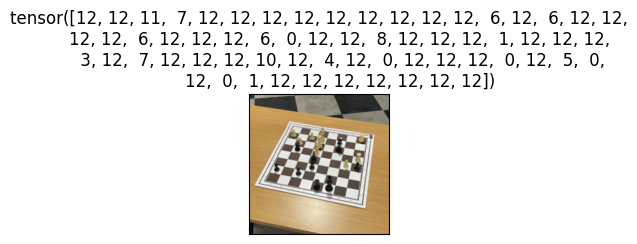

In [9]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(1):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    img = images[idx]
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(labels[idx])

In [58]:
import matplotlib.image as mpimg
img = mpimg.imread(image_id_to_path[0])
fig, ax = plt.subplots()
ax.imshow(img)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/1/G001_IMG000.jpg'

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_board_corners(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # edge detection
    edges = cv2.Canny(blur, 50, 150)

    # close gaps in lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    dilated = cv2.dilate(edges, kernel, iterations=2)

    # find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    image_area = img.shape[0] * img.shape[1]

    for cnt in contours:
        epsilon = 0.02 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        area = cv2.contourArea(approx)

        # take large contour (hopefully, the board)
        if len(approx) == 4 and area > image_area * 0.05:
            return np.float32([pt[0] for pt in approx]), dilated

    return None, dilated

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]     # Top-left
    rect[2] = pts[np.argmax(s)]     # Bottom-right
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # Top-right
    rect[3] = pts[np.argmax(diff)]  # Bottom-left
    return rect

def draw_corners(img, corners):
    img_copy = img.copy()
    labels = ["Top-Left", "Top-Right", "Bottom-Right", "Bottom-Left"]
    ordered = order_points(corners)

    for i, pt in enumerate(ordered):
        pt_int = tuple(np.int32(pt))
        cv2.circle(img_copy, pt_int, 10, (0, 0, 255), -1)
        cv2.putText(img_copy, labels[i], (pt_int[0] + 5, pt_int[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

    for i in range(4):
        pt1 = tuple(np.int32(ordered[i]))
        pt2 = tuple(np.int32(ordered[(i + 1) % 4]))
        cv2.line(img_copy, pt1, pt2, (0, 255, 0), 2)

    return img_copy


def warp_board(img, corners, output_size=400):
    src_pts = order_points(corners)
    dst_pts = np.array([
        [0, 0],
        [output_size-1, 0],
        [output_size-1, output_size-1],
        [0, output_size-1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(img, M, (output_size, output_size))
    return warped

def slice_squares(warped, square_size=50):
    squares = []
    for row in range(8):
        for col in range(8):
            x1 = col * square_size
            y1 = row * square_size
            square = warped[y1:y1 + square_size, x1:x1 + square_size]
            squares.append(square)
    return squares

def preprocess_chessboard(image_path, output_size=400, display=True):
    img = cv2.imread(image_path)
    corners, debug_dilated = detect_board_corners(img)

    if corners is None:
        return
        raise ValueError("Board corners could not be detected.")

    corner_overlay = draw_corners(img, corners)
    warped = warp_board(img, corners, output_size)
    squares = slice_squares(warped, square_size=output_size // 8)

    if display:
        titles = ["Original", "Dilated Edges", "Corner Overlay", "Warped Top-Down"]
        images = [img, debug_dilated, corner_overlay, warped]

        plt.figure(figsize=(60, 20))
        for i in range(4):
            plt.subplot(1, 4, i + 1)
            img_disp = images[i]
            if len(img_disp.shape) == 2:
                plt.imshow(img_disp, cmap='gray')
            else:
                img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)
                plt.imshow(img_disp)
            plt.title(titles[i])
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    return warped, squares


In [65]:
# for i in range(5):
#     print(f"\n--- Image {i+5} ---")

#     try:
#       warped, squares = preprocess_chessboard(image_id_to_path[i+5], display=True)
#     except:
#       print("Error")

# warped, squares = preprocess_chessboard(image_id_to_path[103], display=True)
# print(image_id_to_path[103])
# image = cv2.imread(image_id_to_path[103])
# cv2_imshow(image)


valid_ids = []
error_ids = []
invalid_warp_ids = []

for i in range(100):
    try:
        warped, squares = preprocess_chessboard(image_id_to_path[i+100], display=False)
        if warped is None or np.std(warped) < 5:  # Low std = nearly solid color
            invalid_warp_ids.append(i+100)
        else:
            valid_ids.append(i+100)
    except Exception as e:
        error_ids.append(i+100)

print("✅ Valid IDs:", valid_ids)
print("❌ Error IDs (exception raised):", error_ids)
print("⚠️ Invalid Warp IDs (bad output):", invalid_warp_ids)



/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K/images/1/G001_IMG000.jpg


AttributeError: 'NoneType' object has no attribute 'clip'

In [54]:
print(len(valid_ids))
print(len(error_ids))
print(len(invalid_warp_ids))

29
9
12


In [75]:
X = []  # warped images
y = []  # labels (FEN -> label vector)

valid_ids = []
error_ids = []
invalid_warp_ids = []

train_chessred2k_ids = annotations['splits']['chessred2k']['train']['image_ids']
count = 0
for i in train_chessred2k_ids:

    path = image_id_to_path.get(i)
    if path is None:
        error_ids.append(i)
        continue

    try:
        warped, _ = preprocess_chessboard(path, display=False)
        if warped is None or np.std(warped) < 5:
            invalid_warp_ids.append(i)
            continue

        pieces = image_to_pieces[i]
        fen = pieces_to_fen(pieces)
        label = fen_to_label_vector(fen)

        X.append(warped)
        y.append(label)
        valid_ids.append(i)

    except Exception as e:
        error_ids.append(i)

print("✅ Total valid images:", len(valid_ids))
print("❌ Total errors:", len(error_ids))
print("⚠️ Total invalid warped:", len(invalid_warp_ids))


✅ Total valid images: 917
❌ Total errors: 227
⚠️ Total invalid warped: 298


In [76]:
print("Valid ids: ", val_ids)
print("Error ids: ", error_ids)
print("Invalid warp ids: ", invalid_warp_ids)

Valid ids:  [792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 5387, 5388, 5389, 5390, 5391, 5392, 5393, 5394, 5395, 5396, 5397, 5398, 5399, 5400, 5401, 5402, 5403, 5404, 5405, 5406, 5407, 5408, 5409, 5410, 5411, 5412, 5413, 5414, 5415, 5416, 5417, 5418, 5419, 5420, 5421, 5422, 5423, 5424, 5425, 5426, 5427, 5428, 5429, 5430, 5431, 5432, 5433, 5434, 5435, 5436, 5437, 5438, 5439, 5440, 5441, 5442, 5443, 5444, 5445, 5446, 5447, 5448, 5449, 5450, 545